Run the following cell to install Fenics on Google Colab.

In [ ]:
!wget "https://fem-on-colab.github.io/releases/fenics-install-real.sh" -O "/tmp/fenics-install-real.sh" && bash "/tmp/fenics-install-real.sh"
import dolfin

In [ ]:
import fenics
from fenics import *
import numpy as np
from collections import OrderedDict
import matplotlib.pyplot as plt

# Linear convection-diffusion equation

Consider the stationnary convection-diffusion equation

\begin{equation}
-\kappa \Delta u + \beta \cdot \nabla u + \gamma u= f \quad x\in\Omega :=(0,1)^2 \\
u|_{\partial \Omega}=0,
\end{equation}

with the following parameters:

\begin{equation}
\kappa = 10^{-2}, \quad \beta=[0.5, 1.0], \quad \gamma=0, \quad f(x,y)=\begin{cases} +1 & y\geq 2x, \\ -1 & y<2x\end{cases}
\end{equation}



## Numerical solution

In [ ]:
# Constants
kappa = 10e-2
beta1 = 1/2/(1.25)**0.5
beta2 = 1/(1.25)**0.5

In [ ]:
# Fix Finite elements
mesh = UnitSquareMesh(1000, 1000)
V = FunctionSpace(mesh, "P", 1)

u_D = Constant(0.0)

def boundary(x, on_boundary):
    return on_boundary

bc = DirichletBC(V, u_D, boundary)

u = TrialFunction(V)
v = TestFunction(V)

f = Expression("x[1] >= 2*x[0] ? 1 : -1", degree=1)

beta = Constant((beta1, beta2))

a = Constant(kappa) * inner(nabla_grad(u), nabla_grad(v)) * dx + inner(beta, nabla_grad(u)) * v * dx

L = f*v*dx

u = Function(V)
solve(a == L, u, bc)

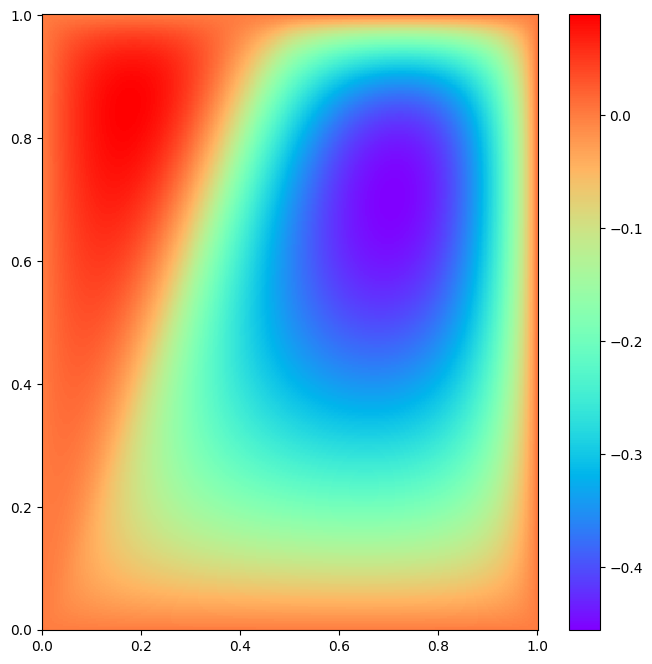

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)

x = np.linspace(0,1, 400)
xx, yy = np.meshgrid(x, x)

zz = np.zeros((400, 400))

for i in range(400):
    for j in range(400):
        zz[i,j] = u(xx[i, j], yy[i, j])

h = ax.pcolormesh(x, x, zz, shading="auto", cmap="rainbow")
fig.colorbar(h)
plt.show()

## PINN's Solution

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

class DNN(keras.Model):
    def __init__(self, layers_size):
        super(DNN, self).__init__()
        self.depth = len(layers_size) - 1
        self.layers_list = []
        for i in range(self.depth - 1):
            self.layers_list.append(layers.Dense(layers_size[i+1], activation='tanh'))
        self.layers_list.append(layers.Dense(layers_size[-1]))

    def call(self, inputs):
        x = inputs
        for layer in self.layers_list:
            x = layer(x)
        return x

class PINN:
    def __init__(self, layers_size):
        self.dnn = DNN(layers_size)

    def generate_train_data_grid(self, num):
        # Boundary
        x = tf.cast(tf.linspace(0, 1, num), tf.float32)
        bc1 = tf.stack([tf.zeros(num), x], 1)
        bc2 = tf.stack([tf.ones(num), x], 1)
        bc3 = tf.stack([x, tf.zeros(num)], 1)
        bc4 = tf.stack([x, tf.ones(num)], 1)

        self.boundary = tf.concat([bc1, bc2, bc3, bc4],0)

        # Interior
        xx, yy = tf.meshgrid(x[1:-1], x[1:-1])
        self.interior = tf.stack([tf.reshape(xx, [-1]), tf.reshape(yy, [-1])], 1)

    def generate_train_data_random_uniform(self, num):
        eps = 1e-6
        self.interior = tf.random.uniform((num*num, 2))

        bc1 = tf.stack([tf.zeros(num), tf.random.uniform((num,))], 1)
        bc2 = tf.stack([tf.ones(num), tf.random.uniform((num,))], 1)
        bc3 = tf.stack([tf.random.uniform((num,)), tf.zeros(num)], 1)
        bc4 = tf.stack([tf.random.uniform((num,)), tf.ones(num)], 1)
        self.boundary = tf.concat([bc1, bc2, bc3, bc4],0)


    def u(self, x):
        return self.dnn(x)

    def f(self, x):
        return tf.math.sign(x[:, 1]-2*x[:, 0]) - tf.math.sign(2*x[:, 0]-x[:, 1])

    def loss(self):
        # Interior
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(self.interior)
            u = self.u(self.interior)
            u_xy = tape.gradient(u, self.interior)
        u_xxyy = tape.gradient(u_xy, self.interior)
        del tape

        interior_loss = -kappa * (u_xxyy[:, 0] + u_xxyy[:, 1]) + beta1*u_xy[:, 0] + beta2*u_xy[:, 1] - self.f(self.interior)

        # Boundary
        boundary_loss = self.u(self.boundary)

        loss = tf.reduce_mean(tf.square(interior_loss)) + tf.reduce_mean(tf.square(boundary_loss))

        return loss

    def train(self, epochs, num, lr=0.001, distr="grid"):
        if distr == "grid":
            self.generate_train_data_grid(num)
        else:
            self.generate_train_data_random_uniform(num)

        losses = np.zeros(epochs)
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
        for i in range(epochs):
            with tf.GradientTape() as tape:
                loss_value = self.loss()
            grads = tape.gradient(loss_value, self.dnn.trainable_weights)
            optimizer.apply_gradients(zip(grads, self.dnn.trainable_weights))
            losses[i] = loss_value.numpy()
            if i%100==0:
              print("iter {} loss is: {}".format(i, losses[i]) )
        return losses

    def plot_solution(self):
        x = np.linspace(0, 1, 400)
        xx, yy = np.meshgrid(x, x)
        data = np.stack((xx, yy), axis=2).reshape(-1, 2)
        u = self.dnn(data)

        fig = plt.figure(figsize=(10,10))
        ax = fig.add_subplot(111)

        h = ax.pcolormesh(x, x, u.numpy().reshape(400, 400).T, shading="auto", cmap="rainbow")
        fig.colorbar(h)
        ax.plot(self.interior[:, 0], self.interior[:, 1], "kx", markersize=4, clip_on=False, alpha=0.5)
        ax.plot(self.boundary[:, 0], self.boundary[:, 1], "kx", markersize=4, clip_on=False, alpha=0.5)
        plt.show()

model = PINN([2, 50, 50, 50, 1])
losses = model.train(5000, 45, lr=0.001)


In [ ]:
losses = model.train(5000, 45, lr=0.0001)

iter 0 loss is: 0.0009358036331832409
iter 100 loss is: 0.0007920011994428933
iter 200 loss is: 0.0007843328639864922
iter 300 loss is: 0.0007812497206032276
iter 400 loss is: 0.000764157623052597
iter 500 loss is: 0.0007529308786615729
iter 600 loss is: 0.0007414965657517314
iter 700 loss is: 0.0007291763904504478
iter 800 loss is: 0.0007171484758146107
iter 900 loss is: 0.0007048542029224336
iter 1000 loss is: 0.0006927427602931857
iter 1100 loss is: 0.000699879601597786
iter 1200 loss is: 0.0006686730775982141
iter 1300 loss is: 0.0006644771201536059
iter 1400 loss is: 0.0006491002859547734
iter 1500 loss is: 0.0006349663017317653
iter 1600 loss is: 0.0006244324031285942
iter 1700 loss is: 0.0006144860526546836
iter 1800 loss is: 0.0006049639196135104
iter 1900 loss is: 0.0005958700203336775
iter 2000 loss is: 0.000587242713663727
iter 2100 loss is: 0.0005800823564641178
iter 2200 loss is: 0.0005708594108000398
iter 2300 loss is: 0.0005643871845677495
iter 2400 loss is: 0.0005700901

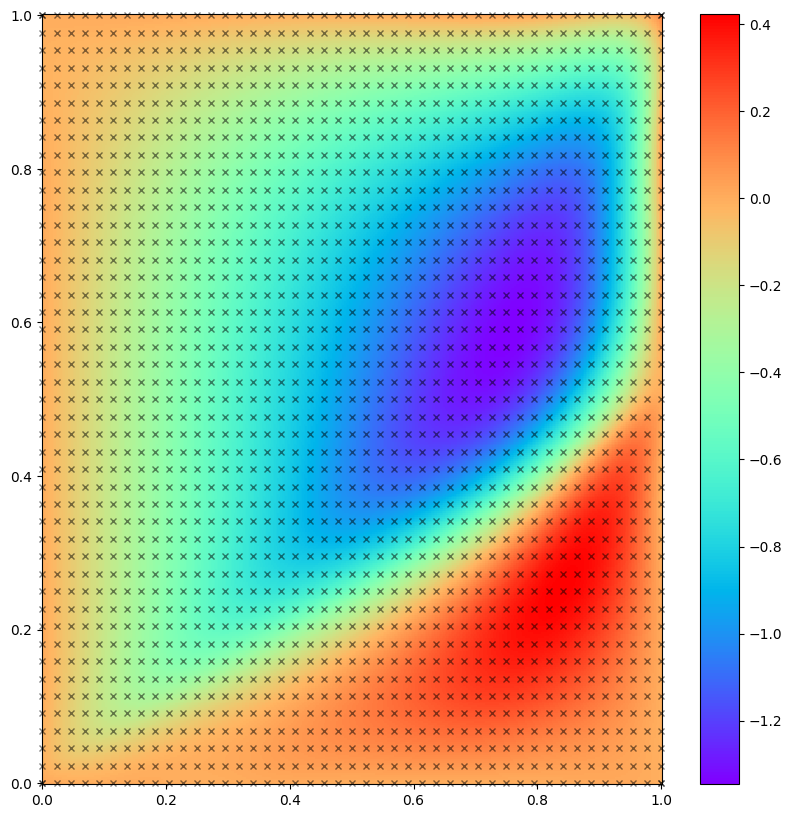

In [ ]:
model.plot_solution()